# Višeklasna klasifikacija korišćenjem neuronskih mreža

Zadatak:
* dizajnirati i natrenirati klasfikator koji slici cifre pridružuje cifru koja se na njoj nalazi.
* skup podataka: MNIST skup slika cifara
* dizajn resenja: koristićti neuronsku mrežu sa propagacijom unapred

Disclaimer: već na narednim vežbama, u istom zadatku klasifikacije slika, uvešćemo konvolutivne neuronske mreže koje predstavlju prirodniji izbor za resavanje ovog problema.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split

In [3]:
RANDOM_STATE = 1219
N_EPOCHS = 50
BATCH_SIZE = 1024
np.random.seed(RANDOM_STATE)

In [4]:
def get_device():
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def bind_gpu(data):
  device = get_device()
  if isinstance(data, (list, tuple)):
    return [bind_gpu(data_elem) for data_elem in data]
  else:
    return data.to(device, non_blocking=True)

In [5]:
print(get_device())

cpu


## Dataset

MNIST je skup podataka koji sadrži slike rukom pisanih cifara. Slika ima ukupno 70.000 od čega se obično 60.000 slika koristi za treniranje, a preostalih 10.000 za testiranje. Sve slike u skupu podataka su dimenzije 28px x 28px i u crno-belom su modu. Više o MNIST skupu podataka, kao i rezultatima dobijenim prvim algoritmima mašinskog učenja, možete pročitati [ovde](http://yann.lecun.com/exdb/mnist/).

In [6]:
from torchvision import datasets, transforms
from torch import utils

norm_mean = 0
norm_stddev = 1

train_valid_dataset = datasets.MNIST('~/datasets/', train=True, download=True,
                                     transform=transforms.Compose([
                                         transforms.ToTensor(),
                                         transforms.Normalize((norm_mean,), (norm_stddev,))
                                         ]))

test_dataset = datasets.MNIST('~/datasets/', train=False, download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((norm_mean,), (norm_stddev,))
                                  ]))

print('train_valid:', train_valid_dataset.data.shape, train_valid_dataset.targets.shape)
print('test:', test_dataset.data.shape, test_dataset.targets.shape)

train_valid: torch.Size([60000, 28, 28]) torch.Size([60000])
test: torch.Size([10000, 28, 28]) torch.Size([10000])


Od skupa za trening i validaciju možemo napraviti dva dataloader-a, jedan za trening i drugi za validaciju, korišćenjem `SubsetRandomSampler` klase. 

In [7]:
from torch.utils.data import SubsetRandomSampler

valid_size = 0.2
pin_memory = True # U slučaju da se koristi GPU može se ubrzati učitavanje podataka
num_workers = 4

num_train_valid_samples = len(train_valid_dataset)
split = int(np.floor(valid_size * num_train_valid_samples))
indices = list(range(num_train_valid_samples))
np.random.seed(RANDOM_STATE)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_valid_dataset, batch_size=BATCH_SIZE, sampler=train_sampler,
                                           num_workers=num_workers, pin_memory=pin_memory)
valid_loader = torch.utils.data.DataLoader(train_valid_dataset, batch_size=BATCH_SIZE, sampler=valid_sampler,
                                           num_workers=num_workers, pin_memory=pin_memory)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=None,
                                           num_workers=num_workers, pin_memory=pin_memory)


In [8]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
batch_idx, example_data.shape, example_targets.shape

(0, torch.Size([1024, 1, 28, 28]), torch.Size([1024]))

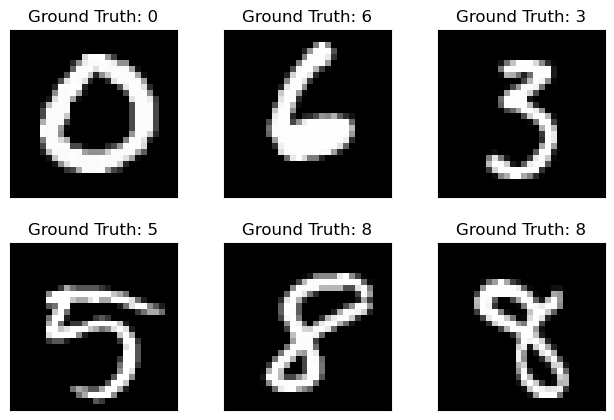

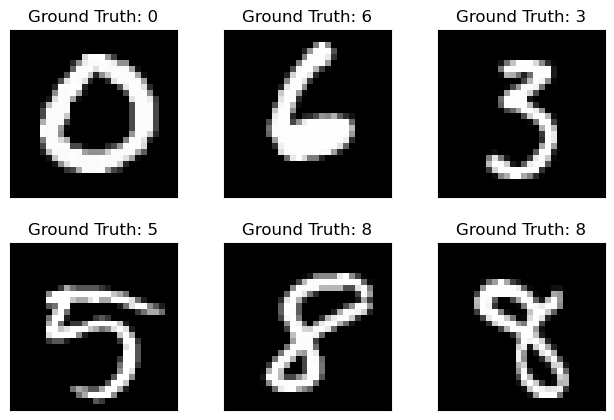

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [10]:
# for example, print 7-th instance
i = 5
print(example_data[i].shape, example_data[i][0].shape, example_data[i][0][0], example_targets[i])

torch.Size([1, 28, 28]) torch.Size([28, 28]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]) tensor(8)


## Dizjan Neuronske Mreze


Na slici je prikazana arhitekture mreže koju ćemo kreirati.

<img src="assets/mlp_mnist.png" />

#### Ulazni sloj

Ulaz u mrežu je "ispravljena" slika dimenzije 784 piksela.

<img src="assets/mnist-input.png" />


#### Skriveni slojevi

Mreža ima dva skrivena sloja, jedan dimenzije 128 neurona i drugi dimenzije 64 neurona. Oba sloja kao aktivaciju koriste *ReLu* funkciju.



#### Izlazni sloj

Izlazni sloj mreže ima 10 neurona. Svaki od njih odgovara jednoj od cifara od 0 do 9. Ideja je da vrednosti izlaza predstavljaju verovatnoće pripadanja odgovarajućoj klasi cifara. Preciznije, ako se za ulaz *img* koji predstavlja sliku dobija izlaz oblika $(v_0, v_1, v_2, v_3, v_4, v_5, v_6, v_7, v_8, v_9)$ rezultat tj. klasa pripadanja će biti ona vrednost $i$ za koju je $v_i$ maksimalno. Na primer, ako $v_4$ ima najveću vrednost, onda zaključujemo da slika *img*  predstavlja broj 4.

Zato ćemo u poslednjem sloju mreže kao aktivacionu funkciju iskoristiti funkciju mekog maksimuma (engl. softmax) koja vrednost $v_i$ mapira u vrednost $\frac{e^{v_i}}{\sum_j{e^{v_j}}}$

Pored ovih vrednosti, korisno je vratiti i vrednosti fukncije pre operacije mekog maksimuma, zato što se zbog numeričke stabilnosti algoritma one koriste za izračunavanje funkcije greške.

In [11]:
import torch
import torch.nn as nn

class MNISTClassifier(nn.Module):
    def __init__(self, image_size, number_of_classes):
        super(MNISTClassifier, self).__init__()
        self.flatten = nn.Flatten()  # Convert 2D image to 1D tensor
        self.fc1 = nn.Linear(image_size * image_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, number_of_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        logits = self.fc3(x)
        x = self.softmax(logits)
        return x, logits

## Trening Neuronske Mreze

U zadacima višeklasne klasifikacije, uz aktivaciju mekog maksimuma u zadanjem sloju, obično se kao funkcija gubitka koristi `kategorička unakrsna entropija` (engl. categorical crossentropy). Ona predstavlja uopštenje binarne unakrsne entropije i računa se po formuli $-\sum_i{y_i \cdot log(\hat{y_i})}$ u kojoj $\hat{y_i}$ predstavlja predikciju mreže za instacu $i$, a $y_i$ njenu stvarnu vrednost.

Kao optimizator ćemo koristiti `Adam`.

Pratićemo tačnost kao relevantnu metriku za ocenu klasifikacije.

In [12]:
img_size = 28
number_of_classes = 10

model = MNISTClassifier(img_size, number_of_classes)
model = model.to(get_device())

In [13]:
def count_parameters(model):
  total_params = sum(p.numel() for p in model.parameters())

  # Iterate through the layers and print their details
  for name, layer in model.named_children():
        num_params = sum(p.numel() for p in layer.parameters())
        print(f"Layer: {name}, Parameters: {num_params}")

  return total_params

In [14]:
count_parameters(model)

Layer: flatten, Parameters: 0
Layer: fc1, Parameters: 100480
Layer: relu, Parameters: 0
Layer: fc2, Parameters: 8256
Layer: fc3, Parameters: 650
Layer: softmax, Parameters: 0


109386

Kako ćemo u ovoj svesci više modela trenirati, napisaćemo funkciju za trening.

In [15]:
from tqdm import tqdm
def train_model(model, optimizer, number_of_epochs, train_loader, validation_loader):
    metrics = {
        'train_loss': [],
        'train_accuracy': [],
        'train_steps': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_steps': [],
    }

    device = get_device()
    training_step = 0
    pbar = tqdm(total=number_of_epochs, desc="Training Progress")
    pbar.set_postfix({"loss": -1, "accuracy": -1})
    for epoch in range(number_of_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            probs, logits = model(inputs)

            loss = nn.functional.cross_entropy(logits, labels)
            predicted = torch.argmax(probs, dim=1)
            correct = (predicted == labels).sum().item()
            accuracy = correct / labels.size(0)
            metrics['train_loss'].append(loss.item())
            metrics['train_accuracy'].append(accuracy)
            metrics['train_steps'].append(training_step)
            training_step += 1
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_correct = 0
            val_samples = 0
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                probs, logits = model(inputs)

                loss = nn.functional.cross_entropy(logits, labels, reduction='sum')
                val_loss += loss.item()

                predicted = torch.argmax(probs, dim=1)
                val_correct += (predicted == labels).sum().item()
                val_samples += labels.size(0)

            val_loss /= val_samples
            val_accuracy = val_correct / val_samples
            metrics['val_loss'].append(val_loss)
            metrics['val_accuracy'].append(val_accuracy)
            metrics['val_steps'].append(training_step)

        pbar.set_postfix({"loss": val_loss, "accuracy": val_accuracy})
        pbar.update(1)
    return metrics

def plot_metrics(metrics):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_steps'], metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['val_steps'], metrics['val_loss'], label='Validation Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_steps'], metrics['train_accuracy'], label='Train Accuracy')
    plt.plot(metrics['val_steps'], metrics['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Training Steps')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    predicted_labels, true_labels = [], []
    device = get_device()

    with torch.no_grad():  # No gradient computation during evaluation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            probs, logits = model(inputs)
            total_loss += nn.functional.cross_entropy(logits, labels).item()

            predicted = torch.argmax(probs, dim=1)
            
            predicted_labels.extend(predicted.squeeze().tolist())
            true_labels.extend(labels.tolist())

            total_samples += labels.size(0)
            total_correct += (predicted.squeeze() == labels).sum().item()

    # compute metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
    print(f'Model evaluation on: {dataloader}')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

    # plot
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


Training Progress: 100%|██████████| 10/10 [00:30<00:00,  3.01s/it, loss=0.153, accuracy=0.955]


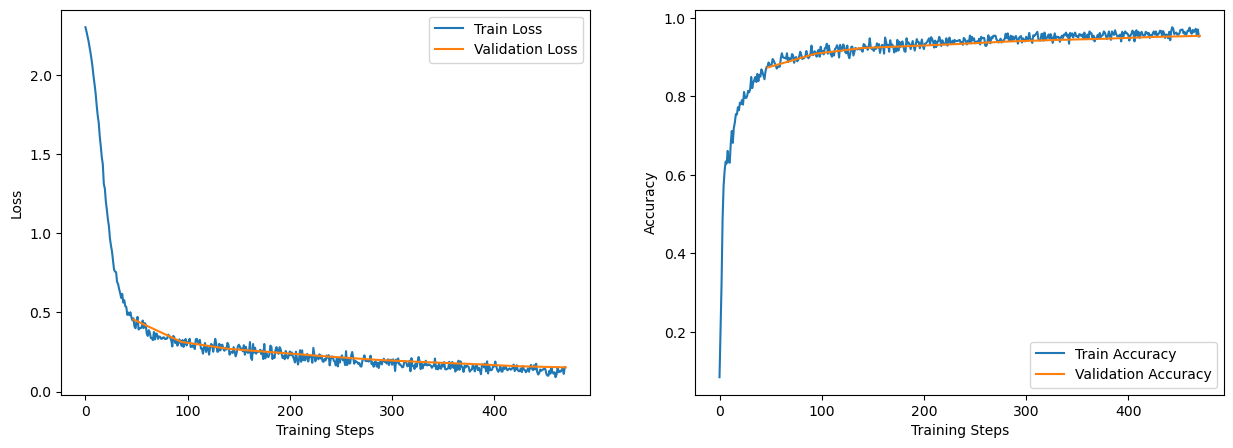

In [16]:
model = MNISTClassifier(img_size, number_of_classes)
bind_gpu(model)

optimizer = optim.Adam(model.parameters())
epochs = 10

metrics = train_model(model, optimizer, epochs, train_loader, valid_loader)
plot_metrics(metrics)

Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x74b40fe45a50>
Accuracy: 0.9545
Precision: 0.9545
Recall: 0.9545
F1 Score: 0.9544
Validation Set: Loss: 0.1532, Accuracy: 0.9545


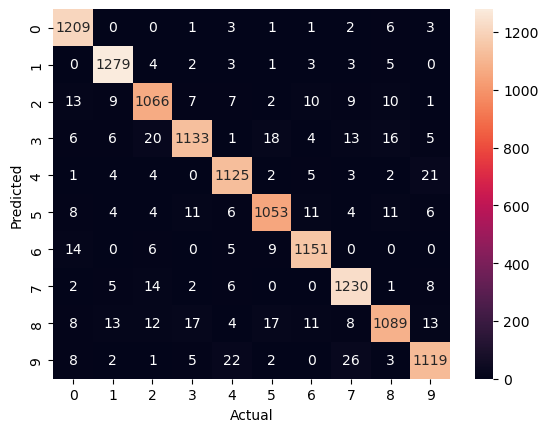

In [17]:
valid_loss, valid_accuracy = evaluate_model(model, valid_loader)
print(f'Validation Set: Loss: {valid_loss:.4f}, Accuracy: {valid_accuracy:.4f}')

## Trening Neuronske Mreze + L2

U opštem slučaju, prilikom analize tačnosti klasifikacije možemo se voditi zaključcima prikazanim na slici. <img src='assets/train_val_accuracy.png'>

Jedan način da se doda regularizacija modelu je uz korišćenje L2 regularizacije: https://stackoverflow.com/questions/42704283/l1-l2-regularization-in-pytorch

Training Progress: 100%|██████████| 10/10 [00:34<00:00,  3.44s/it, loss=0.148, accuracy=0.956]


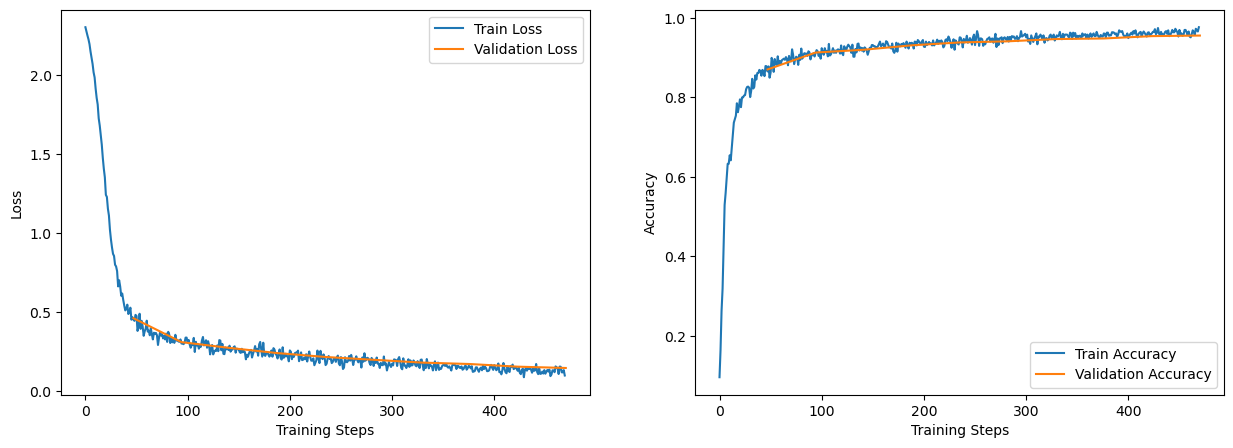

In [18]:

model = MNISTClassifier(img_size, number_of_classes)
bind_gpu(model)
optimizer = optim.AdamW(model.parameters(), weight_decay=5e-4)

metrics = train_model(model, optimizer, epochs, train_loader, valid_loader)
plot_metrics(metrics)

Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x74b40fe45a50>
Accuracy: 0.9556
Precision: 0.9557
Recall: 0.9556
F1 Score: 0.9555
Validation Set: Loss: 0.1472, Accuracy: 0.9556


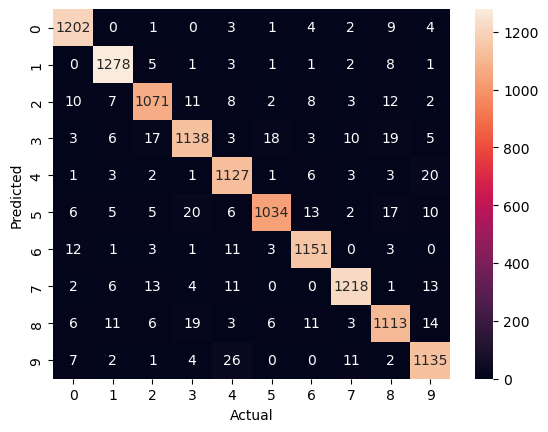

In [19]:
valid_loss, valid_accuracy = evaluate_model(model, valid_loader)
print(f'Validation Set: Loss: {valid_loss:.4f}, Accuracy: {valid_accuracy:.4f}')

## Trening Neuronske Mreze + Dropout

Zbog velikog broja parametara, regularizacije se gotovo pa neizostavno koriste u procesu obučavanja neuronskih mreža. Još jedna tehnika regularizacije je takozvana `dropout` regularizacija. Korišćenjem `dropout` regularizacije isključujemo nasumično odabrane neurone, omogućavamo drugačiji protok podataka kroz mrežu i smanjujemo zavisnosti izlaza od ulaza. Da bi se primenila ova tehnika regularizacije, dovoljno je mreži dodati `Dropout` sloj. Njegov parametar `rate` je verovatnoća isključivanja pojedinačnih neurona.
<img src='assets/dropout.png'>

In [20]:
import torch
import torch.nn as nn

class MNISTClassifier(nn.Module):
    def __init__(self, image_size, number_of_classes, dropout_prob=0.5):
        super(MNISTClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(image_size * image_size, 128)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_prob)  # First dropout layer
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(p=dropout_prob)  # Second dropout layer
        self.fc3 = nn.Linear(64, number_of_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)  # Apply dropout after activation
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)  # Apply dropout after activation
        logits = self.fc3(x)
        x = self.softmax(logits)
        return x, logits

Training Progress: 100%|██████████| 10/10 [00:39<00:00,  3.91s/it, loss=0.173, accuracy=0.95]


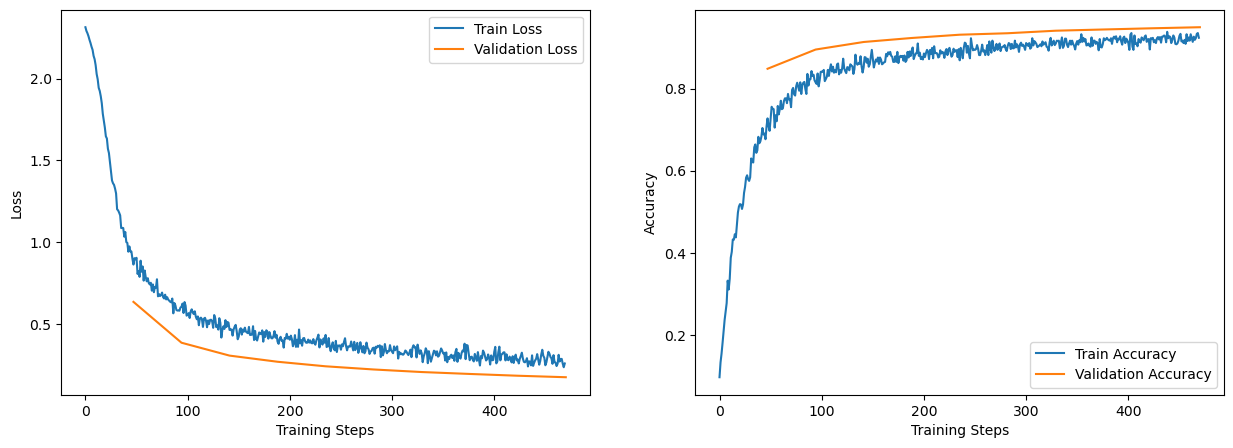

In [21]:
model = MNISTClassifier(img_size, number_of_classes)
bind_gpu(model)
optimizer = optim.Adam(model.parameters())

metrics = train_model(model, optimizer, epochs, train_loader, valid_loader)
plot_metrics(metrics)

Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x74b40fe45a50>
Accuracy: 0.9497
Precision: 0.9498
Recall: 0.9497
F1 Score: 0.9497
Validation Set: Loss: 0.1738, Accuracy: 0.9497


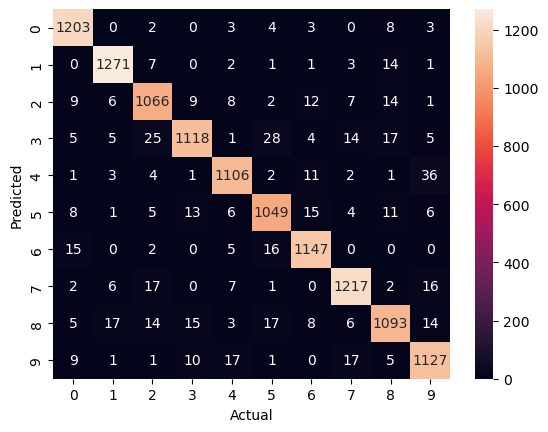

In [22]:
valid_loss, valid_accuracy = evaluate_model(model, valid_loader)
print(f'Validation Set: Loss: {valid_loss:.4f}, Accuracy: {valid_accuracy:.4f}')

Primetimo da je na ovaj način dobijena manja tačnost u odnosu na prethodni vid regularizacie.

# Analiza Prostora Gresaka

Videli smo da model daje dobru ocenu tačnosti. U praksi je značajno izdvojiti i instance na kojima model ne radi dobro u cilju boljeg razumevanja njegovog rada i budućih popravki.

Kreiraćemo prvo niz sa predikcijama modela.

In [23]:
model.eval()
predicted_labels, true_labels = [], []
device = get_device()

with torch.no_grad():  # No gradient computation during evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        probs, logits = model(inputs)
        predicted = torch.argmax(probs, dim=1)
        predicted_labels.extend(predicted.squeeze().tolist())
        true_labels.extend(labels.tolist())

In [24]:
len(predicted_labels), len(true_labels)

(10000, 10000)

Možemo nacrtati, na primer, prvih 20 instanci test skupa i obeležja koja im pridružuje klasifikator.

In [25]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
batch_idx, example_data.shape, example_targets.shape

(0, torch.Size([1024, 1, 28, 28]), torch.Size([1024]))

In [26]:
device = get_device()
predicted_labels, true_labels = [], example_targets.tolist()

model.eval()
with torch.no_grad():
  inputs = example_data.to(device)
  probs, logits = model(inputs)
  predicted = torch.argmax(probs, dim=1)
  predicted_labels.extend(predicted.squeeze().tolist())

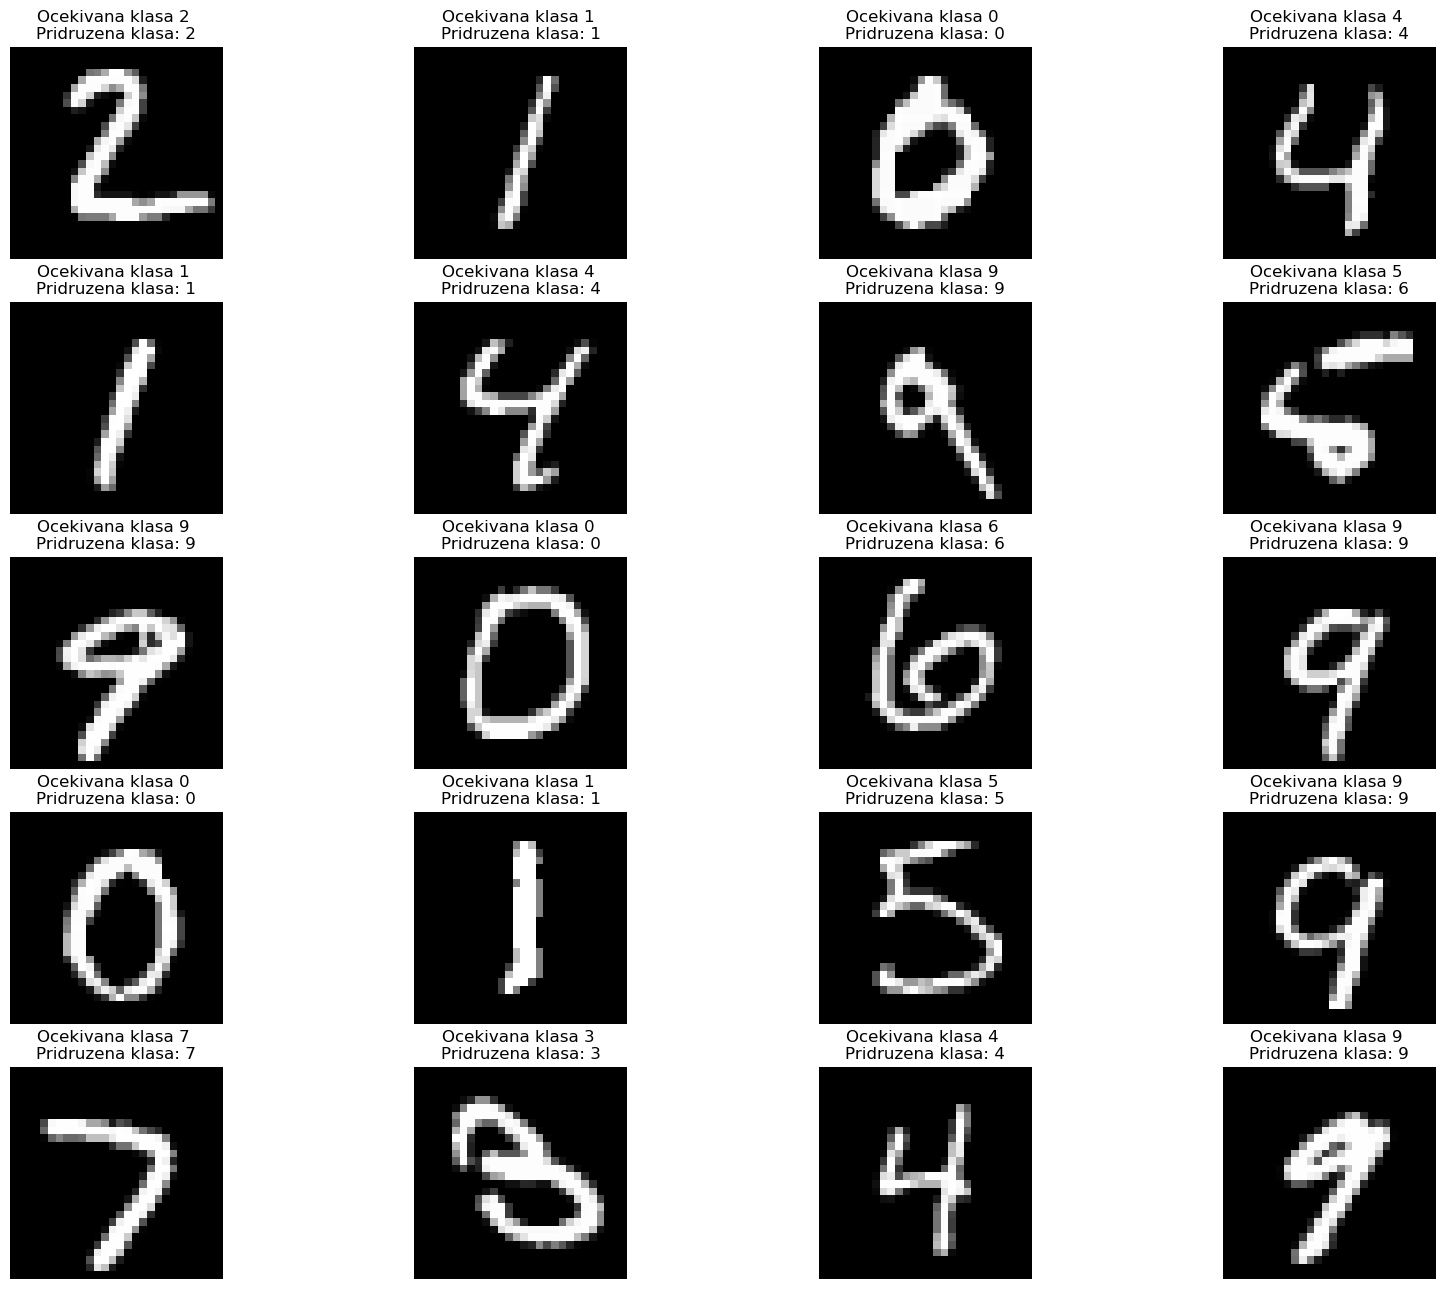

In [27]:
fig = plt.figure(figsize=(20, 16))
image_size = 28
columns = 4
rows = 5

for i in range(1, rows*columns+1):
    fig.add_subplot(rows, columns, i)

    img = example_data[i].reshape(image_size, image_size)

    true_label, predicted_label = true_labels[i], predicted_labels[i]
    plt.title('Ocekivana klasa {} \nPridruzena klasa: {}'.format(true_label, predicted_label))
    plt.axis('off')
    plt.imshow(img, cmap='gray')

plt.show()

Možemo primetiti da je samo jedna slika pogrešno klasifikovana, ali je subjektivni osećaj da model nije mnogo pogrešio jer je broj 5, zaista loše napisan.